# ISS PROJEKT 2022/23 <br />
### 18.12.2022 <br />
## Ondřej Lukášek (xlukas15) 

Cílem tohoto projektu bylo vytvořit syntetické piano. Součástí projektu jsou zdrojové kódy a audio soubory. Všechny zdrojové kódy jsou napsány jak v tomto Python Notebooku (zkoušeno na verzi Pythonu 3.8.2), tak v menších Python programech (zkoušeno pro Python verze 3.8.2, 3.10.7 a 3.11.1), které jsou uloženy v souboru xlukas15.tar.gz, ve složce src. Audio soubory jsou ukládány ve formátu .wav a jsou uloženy v souboru xlukas15.tar.gz, ve složce audio. </br>
V případě, že by se stalo, že by tento notebook z nějakého důvodu nefungoval (já jsem se s tím nesetkal, ale nějak Python notebooku ještě nevěřím), tak všechny kódy, které jsou zde zmíněné, jsou uloženy v src a v úkolech na ně bude odkázáno. </br>
Výběr midi pro můj login: 40 (82.41 Hz), 76 (659.26 Hz), 105 (3520.00 Hz)

Při vypracování budu používat následující knihovny:

In [2]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import scipy.signal as sp

from IPython.display import Audio

## Úloha 4.1

Nyní načteme všechny jednotlivé tóny (respektive celý soubor klavir.waw), jak je napsano v zadání.
Pro načtení jednotlivých tonů použiji návod ze zadání.

In [3]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.35
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read('../audio/klavir.wav')
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) # matrix with all tones - first signals empty,
# but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone

Tony pro můj login (xlukas15) jsou 40 (82.41 Hz); 76 (659.26 Hz) a 105 (3520.00 Hz), ty si postupně uložím do souborů, pojmenovaných podle zadání (a_orig.wav, b_orig.wav, c_orig.wav), a uložim je do složky audio.

In [4]:
sf.write('../audio/a_orig.wav', xall[40], Fs)
sf.write('../audio/b_orig.wav', xall[76], Fs)
sf.write('../audio/c_orig.wav', xall[105], Fs)


Jako první je třeba si vykreslit 3 periody pro moje tóny, to se udělá za pomoci mého následujícího kódu.

In [5]:
def periodPrint(fileName, toneFreq):
    s, Fs = sf.read(fileName)
    N = s.size
    period = 1 / toneFreq
    sample = N * period * 3 * 2
    plt.figure(figsize=(10, 3))
    graphTitle = '3 periody', fileName
    plt.title(graphTitle)
    plt.plot(s[:int(sample) + 1])
    plt.show()

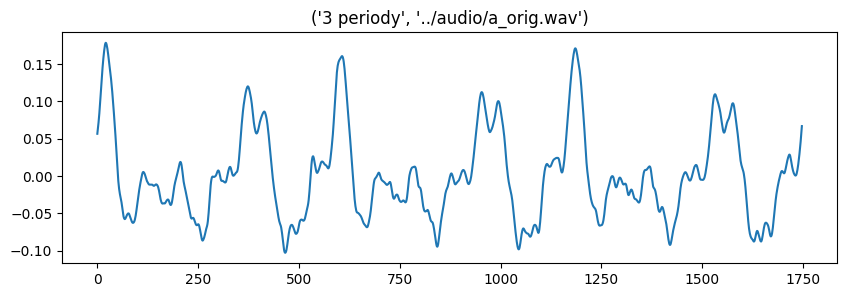

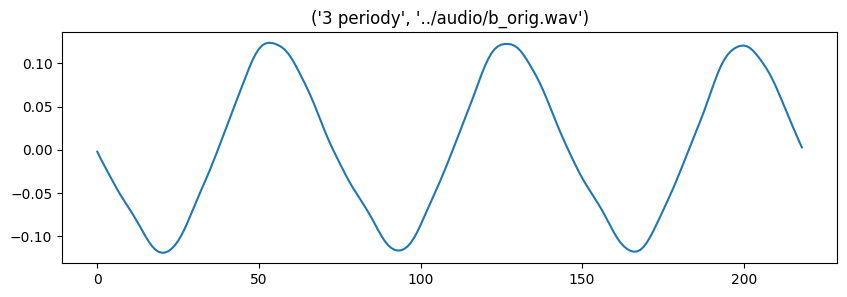

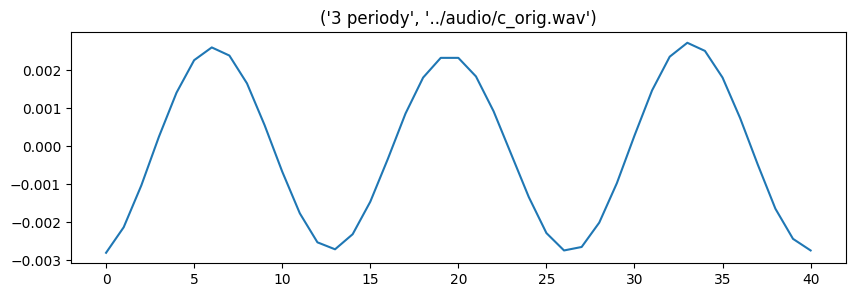

In [6]:
periodPrint('../audio/a_orig.wav', 82.41)
periodPrint('../audio/b_orig.wav', 659.26)
periodPrint('../audio/c_orig.wav', 3520.00)

Nyní je potřeba si vykreslit spektrum pro všechny moje tóny. S tím mi pomohly materiály Kateřiny Žmolíkové, na které je uveden odkaz na stránce předmětu ISS (https://nbviewer.org/github/zmolikova/ISS_project_study_phase/blob/master/Zvuk_spektra_filtrace.ipynb).
Spektrum vytvořím zavoláním mé funkce spectrumPrint().

In [7]:
def spectrumPrint(fileName):
    s, Fs = sf.read(fileName)
    N = s.size
    s_seg_spec = np.fft.fft(s)
    G = 10 * np.log10(1/N * np.abs(s_seg_spec)**2)
    f = np.arange(G.size) / N * Fs

    plt.figure(figsize=(10, 3))
    plt.plot(f[:f.size//2+1], G[:G.size//2+1])
    plt.xlabel('$frekvence [Hz]$')
    graphTitle = 'Spektrum', fileName
    plt.title(graphTitle)

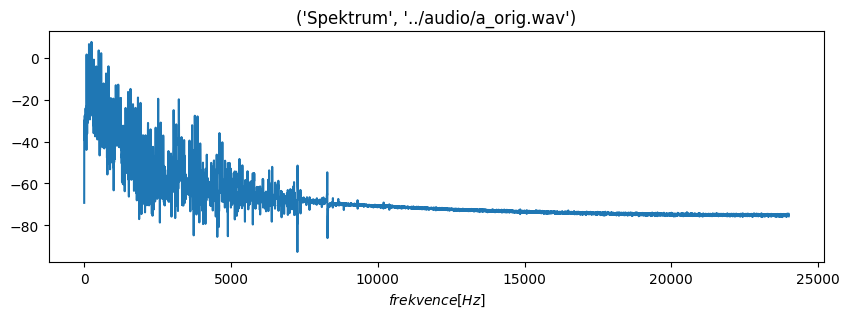

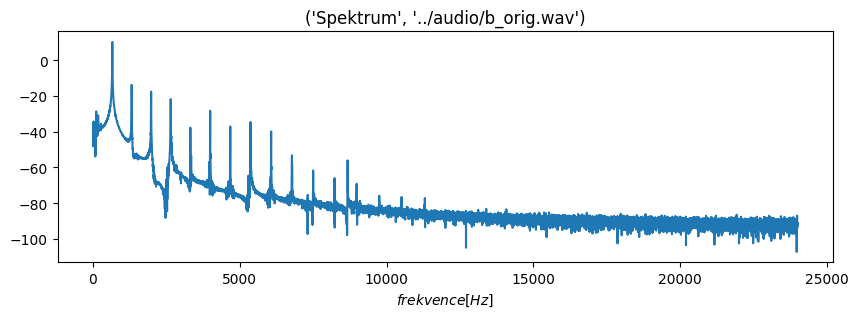

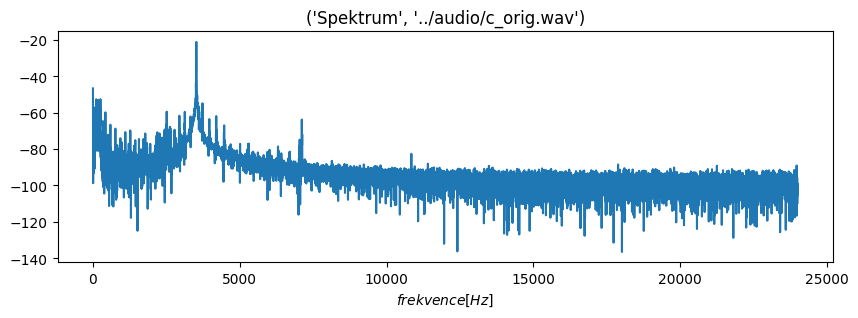

In [8]:
spectrumPrint('../audio/a_orig.wav')
spectrumPrint('../audio/b_orig.wav')
spectrumPrint('../audio/c_orig.wav')

## Úloha 4.2

Nyní mám za úkol určit základní frekvenci u všech tónů. Jelikož by však bylo použití jenom DFT nepřesné (pro nízké tóny), využiji pro nízké tóny autokorelaci. Pro toto zjišťování jsem se inspiroval na stránce Github (https://gist.github.com/endolith/255291/0c0dbc8995bf5c22f56a31036e3094d15bf1b783)
Jelikož následující kousek kódu provádí a vypisuje jak určení základní frekvence pomocí DFT a autokorelace, tak jejich zpřesnění pomocí DTFT, musím upozornit, že pro úlohu 4.2 je potřeba si všímat pouze první frekvence. Tedy pokud je na řádku napsáno "FFT or corelation for midi  24 is:   32.8 Hz   DTFT:   34.1 Hz", zajímá nás pouze první frekvence (32.8 Hz). </br>
Lze si všimnout, že tóny nejsou úplně nejpřesnější, pravděpodobně je to z důvodu, že piano mohlo být lehce rozladěno při nahrávání, Zároveň je výsledek určitě znepřesněn díky DFT, které má tendenci být v nižších frekvencích nepřesné. Kvůli bylo pro nízké frekvence využito autokorelace, ale ani ta není všespásná. Největší rozdíly budou zhruba ve středních tónech (kolem midi 40), kde je užito buď autokorelace nebo DFT a ani jedna z těchto metod nemusí být v daných místech dostatečně přesná.

## Úloha 4.3

Pro vypočtení DTFT jsem naprogramoval funkce makeDTFT a matchDTFT. Vybral jsem si metodu, kde určujeme +-2 koeficienty DFT, protože mi přišla snadnější pro přizpůsobení kódu. </br>
Určitě by bylo vhodné opět zmínit, kde se nechází výpočet DTFT, a je to druhá frekvence výstupu programu. To znamená, že pokud program vypíše "FFT or corelation for midi  24 is:   32.8 Hz   DTFT:   34.1 Hz", zajímá nás druhá frekvence (34.1 Hz).</br>
Je možné si všimnout toho, že tato funkce opět v nízkých frekvencích není úplně přesná. Dle mého názoru je to z důvodu, že byť se jedná o něco přesnější formu DFT, stále se o DFT jedná, a to není na nízké frekvence přesné. Moji myšlenku posiluje fakt, že ve vyšších tónech (stejně jako u DFT) dochází k zlepšení přesnosti výpočtu frekvence. Některé nuance mohou být opět způsobeny lehce rozladěným klavírem. Lepším výsledkům by také napomohla větší vzorkovací frekvence, při které by se přesnost DTFT opět o něco málo zvýšila.

In [9]:
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

def makeDTFT(s, fs, freq):
    N = s.size
    sampleTime = float(N) / fs
    x = np.linspace(0, freq * sampleTime * 2 * np.pi, num = 24000)
    ySin = np.sin(x)
    yCos = np.cos(x)
    im = np.dot(s, ySin)
    re = np.dot(s, yCos)
    return complex(re, im)

def matchDTFT(s, fs, rawFreq, sweep):
    maxVal = 0
    exactFreq = rawFreq
    for i in range(int(sweep * 2 * 10)):
        freq = rawFreq - float(sweep) + float(i) / 10.0
        res = np.abs(makeDTFT(s, fs, freq))
        if res > maxVal:
            maxVal = res
            exactFreq = freq
    return exactFreq

MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.35
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read('../audio/klavir.wav')
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) # matrix with all tones - first signals empty,
# but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
midiNumber = 24
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone
    # misto 's' ted pracujeme s 'x'
    N = x.size
    if midiNumber < 47:
        # Calculate autocorrelation and throw away the negative lags
        corr = sp.fftconvolve(x, x[::-1], mode='full')
        corr = corr[int(len(corr)/2):]

        # Find the first low point
        d = np.diff(corr)
        start = find(d > 0)[0]

        # Find the next peak after the low point (other than 0 lag).  This bit is 
        # not reliable, due to peaks that occur between samples.
        peak = np.argmax(corr[start:]) + start
        freq = Fs / peak
    else:
        sSegSpec = np.fft.fft(x)
        i = np.argmax(abs(np.split(sSegSpec, 2)[0]))
        freq = Fs * i / N 
    print('FFT or corelation for midi', '{:>3}'.format(midiNumber), 'is:', '{:>6}'.format(round(freq, 1)), "Hz", "  DTFT:", '{:>6}'.format(round(matchDTFT(x, Fs, freq, 4), 1)), "Hz")
    midiNumber = midiNumber + 1

FFT or corelation for midi  24 is:   32.8 Hz   DTFT:   34.1 Hz
FFT or corelation for midi  25 is:   34.8 Hz   DTFT:   34.0 Hz
FFT or corelation for midi  26 is:   36.8 Hz   DTFT:   36.3 Hz
FFT or corelation for midi  27 is:   39.0 Hz   DTFT:   41.0 Hz
FFT or corelation for midi  28 is:   41.3 Hz   DTFT:   45.1 Hz
FFT or corelation for midi  29 is:   43.8 Hz   DTFT:   42.2 Hz
FFT or corelation for midi  30 is:   46.4 Hz   DTFT:   45.6 Hz
FFT or corelation for midi  31 is:   49.2 Hz   DTFT:   46.9 Hz
FFT or corelation for midi  32 is:   52.1 Hz   DTFT:   54.4 Hz
FFT or corelation for midi  33 is:   55.2 Hz   DTFT:   56.6 Hz
FFT or corelation for midi  34 is:   58.5 Hz   DTFT:   59.4 Hz
FFT or corelation for midi  35 is:   61.9 Hz   DTFT:   61.8 Hz
FFT or corelation for midi  36 is:   65.6 Hz   DTFT:   65.1 Hz
FFT or corelation for midi  37 is:   69.5 Hz   DTFT:   68.1 Hz
FFT or corelation for midi  38 is:   73.5 Hz   DTFT:   73.0 Hz
FFT or corelation for midi  39 is:   77.9 Hz   DTFT:   

## Úloha 4.4

Následující funkce mi umožňuje vygenenerovat floating point čísla, která reprezentují mé tóny. Nejdříve se spočítají násobky základní frekvece a doladí se pomocí DTFT. Poté jsou také všechny vyznačeny ve spektru. </br>
Na 10 řádcích se vypisují moduly a fáze pro násobky základní frekvence (frekvence jsou první vypsané číslo). Z nich se potom dají zvolit komplexní hodnoty pro prvních 5 frekvencí nebo reálné pro 10. 

In [11]:
def pianoRepre(fileName):
    s, fs = sf.read(fileName)
    N = s.size

    sSegSpec = np.fft.fft(s)
    G = 10 * np.log10(1/N * np.abs(sSegSpec)**2 + 10e-5)
    f = np.arange(G.size) / N * fs

    i = np.argmax(abs(np.split(sSegSpec, 2)[0]))
    rawFreq = fs * i / N 

    f0 = matchDTFT(s, fs, rawFreq, 4)

    multFreqs = range(1, 11)
    freqs = multFreqs * f0
    # print(freqs)
    accFreqs = np.zeros(10, dtype = float)
    resDTFT = np.zeros(10, dtype = complex)
    for i in range(10):
        accFreqs[i] = matchDTFT(s, fs, freqs[i], 4) # doladujeme na +-2 koeficienty DFT, coz zpusobuje nepresnost pri "nasobeni chyby dft"
        resDTFT[i] = makeDTFT(s, fs, accFreqs[i])
        
    #print(accFreqs)
    resMod = np.zeros(10, dtype = float)
    resPhase = np.zeros(10, dtype = float)
    for i in range(10):
        tmpRes = resDTFT[i]
        resMod[i] = np.abs(tmpRes)
        resPhase[i] = np.angle(tmpRes)
    for i in range(10):
        print("Frekvence", '{:>8.1f}'.format(accFreqs[i]), "Hz", "   Modul:", '{:>7.2f}'.format(round(resMod[i],2)), "   Faze:", '{:>7.2f}'.format(round(resPhase[i],2)))


    plt.figure(figsize=(15,5))
    plt.plot(f[:f.size//2+1], G[:G.size//2+1])
    plt.xlabel('$f[Hz]$')
    plt.grid(alpha=0.5, linestyle='--')
    graphTitle = "Reprezentace klaviru pro", fileName
    plt.title(graphTitle)

    for i in range(10):
        y = 10 * np.log10(1/N * np.abs(resMod[i])**2 + 10e-5)
        plt.plot(accFreqs[i], y, 'x')

    plt.show()

Grafy ukazují spektrum signálů a nalezené body, reprezentující daný tón. Díky ne vždy přesnému určení základní frekvence (hlavně u nejnižšího tónu) jsou vyšší harmonické neustále více posunuty a ne vždy se je daří doladit. Pomohlo by zvýšit interval, ale to pokazilo výsledky autokorelace. V pozdější úloze (4.6) dolaďuji na 1/96 frekvence (osmina tónu).

Frekvence    247.1 Hz    Modul:  512.25    Faze:   -0.06
Frekvence    494.4 Hz    Modul:  245.85    Faze:    1.36
Frekvence    743.0 Hz    Modul:   92.55    Faze:    3.00
Frekvence    992.3 Hz    Modul:   17.18    Faze:   -2.81
Frekvence   1238.2 Hz    Modul:    7.65    Faze:    2.34
Frekvence   1485.2 Hz    Modul:    2.49    Faze:    2.03
Frekvence   1731.3 Hz    Modul:    0.99    Faze:    0.76
Frekvence   1973.1 Hz    Modul:    0.51    Faze:   -2.32
Frekvence   2225.5 Hz    Modul:    0.26    Faze:    0.73
Frekvence   2470.5 Hz    Modul:    0.37    Faze:   -2.64


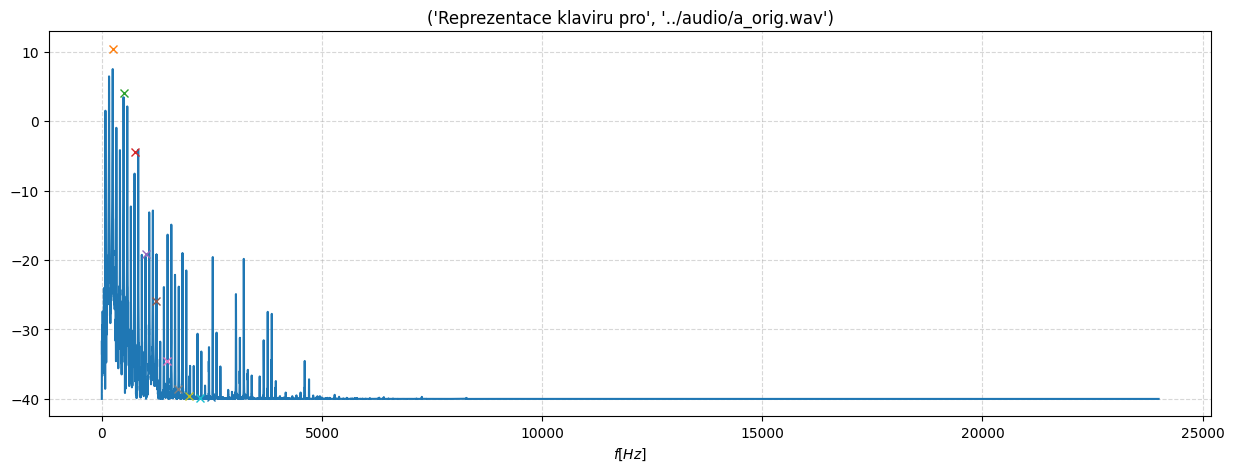

Frekvence    659.1 Hz    Modul:  697.37    Faze:   -1.48
Frekvence   1317.9 Hz    Modul:   31.81    Faze:    1.62
Frekvence   1981.2 Hz    Modul:   15.74    Faze:    1.43
Frekvence   2640.3 Hz    Modul:    1.87    Faze:    2.86
Frekvence   3294.9 Hz    Modul:    0.10    Faze:    0.41
Frekvence   3955.3 Hz    Modul:    0.12    Faze:   -0.81
Frekvence   4616.0 Hz    Modul:    0.06    Faze:   -0.98
Frekvence   5268.8 Hz    Modul:    0.05    Faze:    1.22
Frekvence   5930.2 Hz    Modul:    0.03    Faze:    0.03
Frekvence   6592.2 Hz    Modul:    0.03    Faze:   -0.45


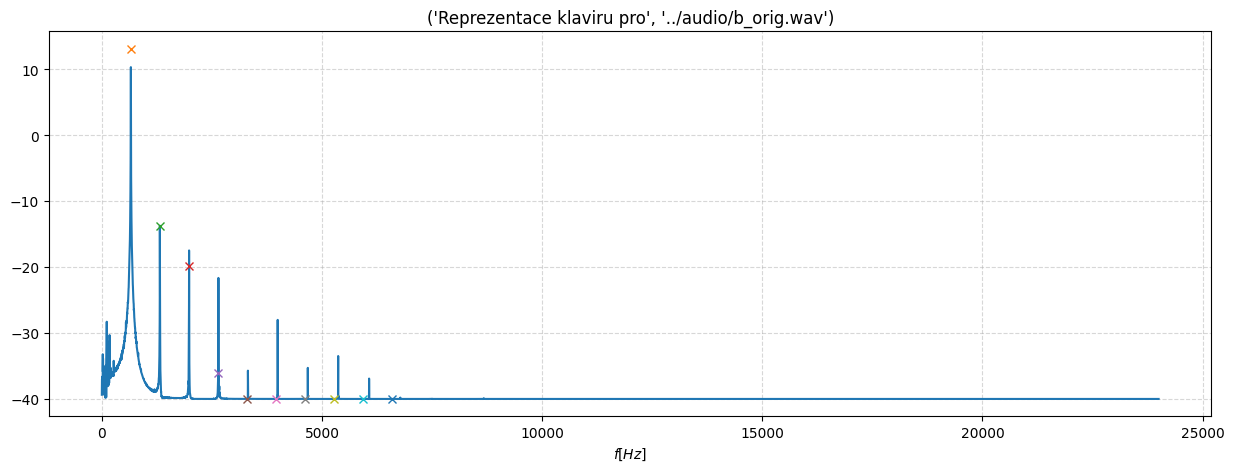

Frekvence   3521.5 Hz    Modul:   14.20    Faze:    2.58
Frekvence   7042.1 Hz    Modul:    0.03    Faze:   -2.15
Frekvence  10565.8 Hz    Modul:    0.00    Faze:   -2.71
Frekvence  14085.4 Hz    Modul:    0.00    Faze:   -2.64
Frekvence  17611.4 Hz    Modul:    0.00    Faze:   -2.90
Frekvence  21128.5 Hz    Modul:    0.00    Faze:   -3.00
Frekvence  24652.1 Hz    Modul:    0.00    Faze:   -3.10
Frekvence  28175.9 Hz    Modul:    0.00    Faze:    2.84
Frekvence  31695.7 Hz    Modul:    0.00    Faze:    2.28
Frekvence  35212.3 Hz    Modul:    0.00    Faze:    2.72


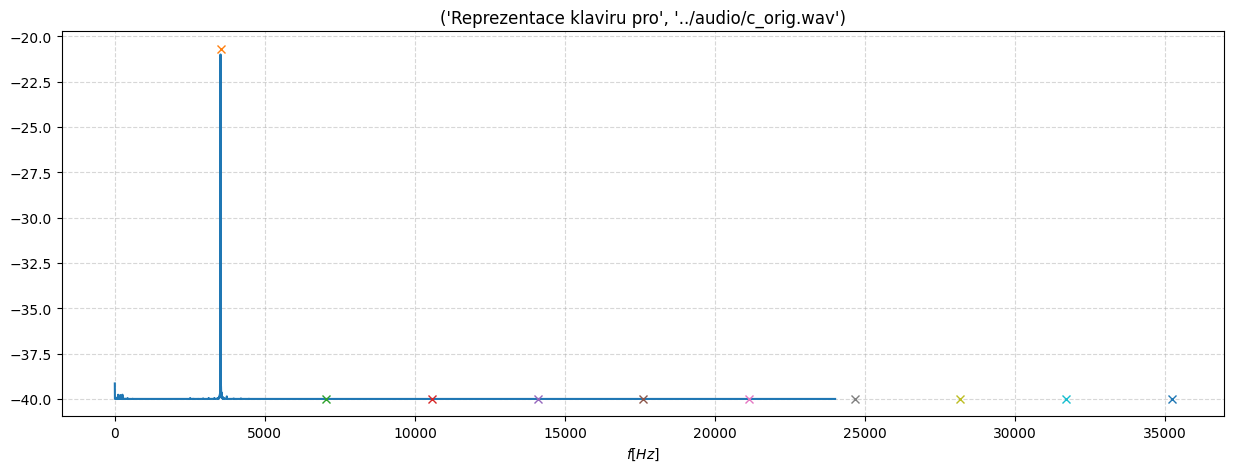

In [12]:
pianoRepre("../audio/a_orig.wav")
pianoRepre("../audio/b_orig.wav")
pianoRepre("../audio/c_orig.wav")

## Úloha 4.5

Syntézu tónů dělám z kompletní FFT. Nejen z bodů definovaných v úloze 4.4. Nejprve jsem tóny skládal pomocí funkce cosinus, ale výsledky nebyly úplně přesné. Po větším studování FFT v numpy jsem zjistil, že se používá funkce exp. Při použití této funkce je výpočet úplně přesný, stejně jako když použiji funkci ifft.

In [13]:
def manIFFTexp(ft):
    N = ft.size
    outSignal = np.zeros(N, dtype = complex)
    x = np.linspace(0, N-1, N)
    for i in range(int(N / 2)):
        if i == 0:
            outSignal += ft[i] * np.ones(N)
        else:
            if i == N-i:
                outSignal += ft[i] * np.exp(1.0j*2 * np.pi * (i) * x / N)
            else:
                outSignal += ft[i] * np.exp(1.0j * 2 * np.pi * (i) * x / N) 
                outSignal += ft[N-i] * np.exp(1.0j * 2 * np.pi * (N-i) * x / N)
    outReal = outSignal.real / N
    return outReal

def manIFFTcos(ft):
    N = ft.size
    outSignal = np.zeros(N, dtype = complex)
    x = np.linspace(0, N-1, N)
    for i in range(int(N / 2)):
        if i == 0:
            outSignal += ft[i] * np.ones(N)
        else:
            if i == N-i:
                outSignal += ft[i] * np.exp(1.0j*2 * np.pi * (i) * x / N)
            else:
                outSignal += ft.real[i] * np.cos(2 * np.pi * (i) * x / N) * 1.732
                #outSignal += sSegSpec.imag[i] * np.sin(2 * np.pi * (i) * x / N) 
                #outSignal += np.abs(sSegSpec[i]) * np.cos(2 * np.pi * (i) * x / N) 
                outSignal += ft.real[N-i] * np.cos(2 * np.pi * (N-i) * x / N) * 1.732
                #outSignal += sSegSpec.imag[N-i] * np.sin(2 * np.pi * (N-i) * x / N)
                #outSignal += np.abs(sSegSpec.real[N-i]) * np.cos(2 * np.pi * (N-i) * x / N)
    outReal = outSignal.real / N
    return outReal

def manIFFTcosLen(ft, l):
    N = ft.size
    outSignal = np.zeros(N*l, dtype = complex)
    x = np.linspace(0, N*l-1, N*l)
    for i in range(int(N / 2)):
        if i == 0:
            outSignal += ft[0] * np.ones(N*l)
        else:
            if i == N-i:
                outSignal += ft[i] * np.exp(1.0j*2 * np.pi * (i) * x / N)
            else:
                outSignal += ft.real[i] * np.cos(2 * np.pi * (i) * x / N) * 1.732
                #outSignal += sSegSpec.imag[i] * np.sin(2 * np.pi * (i) * x / N) 
                #outSignal += np.abs(sSegSpec[i]) * np.cos(2 * np.pi * (i) * x / N) 
                outSignal += ft.real[N-i] * np.cos(2 * np.pi * (N-i) * x / N) * 1.732
                #outSignal += sSegSpec.imag[N-i] * np.sin(2 * np.pi * (N-i) * x / N)
                #outSignal += np.abs(sSegSpec.real[N-i]) * np.cos(2 * np.pi * (N-i) * x / N)
    outReal = outSignal.real / N
    return outReal

def syntTone(srcFile, dstFile, toneFreq):
    s, fs = sf.read(srcFile)
    N = s.size
    sSegSpec = np.fft.fft(s)

    period = 1 / toneFreq
    sample = N * period * 10 * 2
    plt.figure(figsize=(10, 3))
    graphTitle = '10 period', srcFile
    plt.title(graphTitle)
    plt.plot(s[:int(sample) + 1])
    outExp = manIFFTexp(sSegSpec)
    plt.plot(outExp[:int(sample) + 1])
    outCos = manIFFTcos(sSegSpec)
    plt.plot(outCos[:int(sample) + 1])
    plt.show()

    outSec = manIFFTcosLen(sSegSpec, 2)
    sf.write(dstFile, outSec, fs)

V grafech je modře zakreslen původní signál, ale je perfektně překryt oranžovou rekonstrukcí signálů pomocí funkce exp. Zelenou jsou vyznačeny signály, rekonstruované pomocí funkce cos.

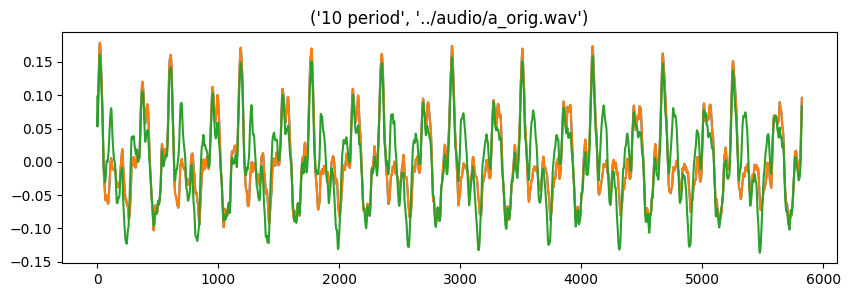

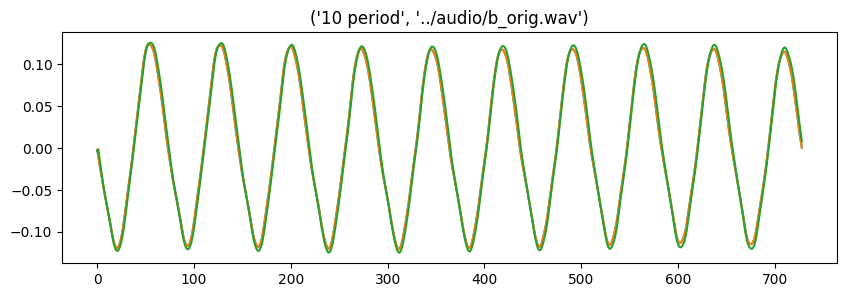

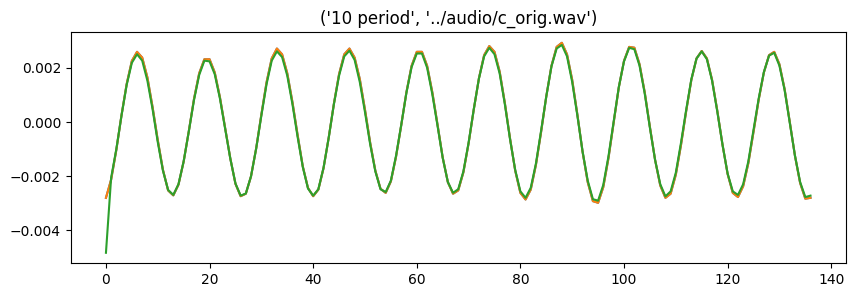

In [14]:
syntTone('../audio/a_orig.wav', '../audio/a.wav', 82.41)
syntTone('../audio/b_orig.wav', '../audio/b.wav', 659.26)
syntTone('../audio/c_orig.wav', '../audio/c.wav', 3520.00)

## Úloha 4.6

Nejprve jsem si vygeneroval pro každý tón z MIDI jeho reprezentaci pomocí 10 harmonických tak, jako je to v úkolu 4.4. Generoval jsem 10 násobků základní frekvence a ke každému komplexní číslo z DTFT. Pro generování tabulky slouží soubor musicTableGenerator.py. Vygenerovanou tabulku (pole) jsem vložil do zdrojového kódu hudebního generátoru jako pole piano. Mírně lepší výsledky byly při výpočtu tónu přes exp funkci místo cos, proto jsem je použil. Potřebný tón o příslušné délce generuje funkce playMIDI. Tato funkce se používá pro každý jeden řádek vstupního souboru skladba.txt a vygenerovaný tón se přičte na odpovídající místo celkové skladby se zohledněním hlasitosti. </br>
Výsledná skladba měla v sobě nehezké "lupání", tak jsem zkusil vynulovat počáteční a koncové body generovaného tónu tak, aby tón navazoval vždy v nule. Tím se "lupání" částečně odstranily, ale stále jsou, byť o dost méně, slyšet.

**Kromě předepsaných 10s audiosouborů out_8k.wav a out_48k.wav program také generuje soubory, které plnou délku a název začíná full_, protože jsem si chtěl skladbu poslechnout celou a také jsem si vyzkoušel další skladby z https://github.com/Lemlak/ISS22_table_generator.**

In [17]:
# MIDI table - generated by musicTableGenerator.py
piano = [
[ 32.97, 8.71-0.41j, 65.38, 966.42-3.07j, 98.09, 564.33+1.00j, 131.00, 496.09-1.19j, 163.70, 295.08+0.64j, 196.51, 361.32+0.91j, 229.42, 395.79+1.39j, 262.13, 64.37+2.83j, 295.14, 142.67-0.46j, 328.05, 211.56+1.17j ],
[ 34.40, 27.98+0.11j, 69.25, 967.95+0.92j, 104.01, 590.85+0.89j, 138.87, 468.08+0.67j, 173.43, 280.90-1.87j, 208.28, 347.35+0.53j, 243.04, 388.42+2.76j, 278.00, 48.46+0.37j, 312.55, 132.66-1.53j, 347.61, 209.39+2.38j ],
[ 36.45, 27.43+2.77j, 73.39, 961.50-1.80j, 110.13, 592.69-0.25j, 147.07, 470.86+1.26j, 183.81, 280.95+0.74j, 220.64, 323.94-1.60j, 257.48, 366.36+2.40j, 294.32, 54.34+1.48j, 331.26, 135.55+1.74j, 368.20, 197.90+0.80j ],
[ 38.92, 24.16-0.55j, 77.74, 942.23+1.16j, 116.77, 556.61-1.95j, 155.79, 448.01+0.84j, 194.72, 286.03+1.82j, 233.74, 323.51+0.93j, 272.76, 355.63+0.14j, 311.89, 62.90+0.93j, 350.81, 140.98+2.21j, 390.14, 196.96+2.97j ],
[ 40.91, 15.49-0.25j, 82.36, 920.47-2.72j, 123.70, 528.85+1.62j, 165.14, 429.93-0.56j, 206.29, 287.21+1.49j, 247.63, 315.97+1.78j, 288.98, 346.95+2.16j, 330.32, 59.85-2.42j, 371.76, 134.26+0.46j, 413.31, 195.72+2.21j ],
[ 44.14, 19.04-2.43j, 87.24, 941.80-0.88j, 131.03, 539.63-1.90j, 174.93, 426.42+3.08j, 218.52, 289.99-0.19j, 262.32, 303.31+0.96j, 306.21, 329.99+2.30j, 349.91, 49.64-1.49j, 393.90, 118.62+2.38j, 437.80, 196.86-1.49j ],
[ 45.94, 17.63-0.68j, 92.46, 931.88+0.34j, 138.78, 528.25-0.22j, 185.40, 399.60-0.81j, 231.62, 275.35+2.83j, 278.05, 284.99-1.71j, 324.47, 320.82+0.05j, 370.89, 41.57-3.10j, 417.31, 122.21+1.15j, 463.83, 191.40-2.20j ],
[ 48.97, 19.28-0.56j, 97.95, 914.09+0.79j, 147.03, 512.55+0.48j, 196.41, 383.94+0.09j, 245.39, 268.01-2.28j, 294.57, 284.91-0.32j, 343.75, 314.06+1.60j, 392.93, 39.99-1.17j, 442.11, 116.89+3.06j, 491.49, 191.18+0.10j ],
[ 52.47, 7.10-2.41j, 103.69, 879.69+0.41j, 155.81, 509.96+0.08j, 208.03, 353.60-0.60j, 260.04, 246.09-2.90j, 312.16, 245.94-1.15j, 364.28, 271.69+0.58j, 416.40, 38.89-2.42j, 468.51, 108.12+1.71j, 520.63, 172.88-1.77j ],
[ 55.60, 8.67+2.18j, 109.87, 853.16-0.57j, 165.04, 482.15-1.47j, 220.31, 324.27-2.78j, 275.29, 257.76+0.56j, 330.46, 250.21+1.70j, 385.73, 261.67+2.99j, 440.80, 43.99-0.74j, 496.18, 106.19+3.07j, 551.65, 174.28-0.65j ],
[ 58.96, 13.18+0.86j, 116.42, 839.92-2.34j, 174.89, 469.99+2.12j, 233.45, 314.91-0.14j, 291.72, 249.43+2.38j, 350.18, 238.66+2.60j, 408.65, 249.26+2.80j, 467.11, 45.03-1.70j, 525.68, 104.53+1.00j, 584.44, 171.11+2.61j ],
[ 61.89, 26.04-0.28j, 123.23, 851.50+1.54j, 185.16, 302.33+2.96j, 247.10, 325.84+1.67j, 309.03, 152.67+1.05j, 370.97, 380.80+0.00j, 432.90, 129.11+0.01j, 494.84, 43.12-0.91j, 556.77, 102.38+2.38j, 618.91, 140.84+2.64j ],
[ 65.09, 17.21-3.04j, 130.56, 843.86-1.99j, 196.24, 292.45-2.31j, 261.71, 326.99+0.66j, 327.39, 154.35-1.64j, 392.86, 375.69+1.56j, 458.43, 125.50-0.28j, 524.01, 42.28-3.13j, 589.78, 98.83-1.41j, 655.75, 135.68-2.82j ],
[ 68.74, 11.91+1.41j, 138.41, 829.66-0.10j, 207.87, 288.86-2.91j, 277.33, 313.29-2.04j, 346.80, 147.55-0.56j, 416.26, 369.51+0.51j, 485.63, 124.24+2.52j, 555.19, 38.53-2.51j, 624.86, 95.07-3.14j, 694.72, 132.94-0.64j ],
[ 73.04, 184.39-0.08j, 146.85, 462.26+2.97j, 220.15, 543.09+2.68j, 293.86, 142.55-2.54j, 366.97, 103.17-0.05j, 440.38, 258.91+0.45j, 514.48, 229.36+2.79j, 588.29, 39.87-3.00j, 661.90, 110.59-1.00j, 735.70, 113.12-0.84j ],
[ 77.31, 183.03+2.81j, 155.63, 458.98+2.71j, 233.25, 531.02-0.95j, 311.28, 138.40+2.92j, 388.90, 97.38+2.44j, 466.72, 250.37-0.36j, 545.04, 223.09-1.68j, 622.96, 37.39+1.30j, 701.29, 100.92+0.46j, 779.51, 104.35-2.71j ],
[ 82.02, 183.87-0.85j, 164.89, 447.04+1.21j, 247.06, 511.89-0.11j, 329.84, 139.61+0.03j, 411.91, 95.73+1.67j, 494.39, 245.90+1.34j, 577.46, 220.64+2.44j, 660.13, 37.96+1.73j, 743.01, 92.55+3.01j, 825.48, 92.08+1.69j ],
[ 87.74, 332.90-0.08j, 174.69, 200.92+2.46j, 262.44, 154.53-0.33j, 350.09, 128.11+1.90j, 437.84, 194.88+3.14j, 525.59, 50.03-1.77j, 613.35, 136.29+1.26j, 701.10, 52.61+0.21j, 788.85, 146.98-0.44j, 876.60, 129.25+2.48j ],
[ 92.88, 306.79+0.93j, 185.02, 184.15-1.58j, 278.06, 146.16+3.06j, 371.01, 116.22+0.23j, 463.45, 200.92+1.95j, 556.09, 60.66-2.41j, 649.24, 147.77+2.00j, 742.18, 59.11+2.03j, 835.22, 150.98+2.56j, 928.57, 125.72+0.75j ],
[ 98.44, 280.10+1.39j, 196.10, 171.05-0.55j, 294.56, 141.36-1.94j, 393.12, 104.89+2.03j, 490.98, 192.30-2.14j, 589.14, 60.48+0.24j, 687.90, 145.50-1.13j, 786.26, 56.90-0.84j, 884.92, 145.79+0.18j, 983.78, 122.65-1.30j ],
[ 104.26, 258.71+0.92j, 207.71, 160.07-1.35j, 312.16, 130.55-3.07j, 416.60, 94.52+0.37j, 520.65, 160.98+2.66j, 625.00, 44.13-0.98j, 729.35, 117.60+2.92j, 833.70, 44.59+2.91j, 938.04, 122.84-3.12j, 1042.39, 112.42+0.59j ],
[ 110.45, 232.10-0.16j, 220.05, 147.41+2.89j, 330.75, 126.72+0.15j, 441.44, 85.88+2.53j, 551.84, 132.13-2.17j, 662.44, 31.93-0.44j, 773.04, 85.66+2.44j, 883.64, 29.75+1.38j, 994.24, 88.74+0.56j, 1104.84, 90.93-3.03j ],
[ 117.05, 208.20-2.00j, 233.13, 137.35-0.75j, 350.30, 121.46+0.72j, 467.67, 80.48+1.37j, 584.15, 153.17+0.54j, 701.22, 49.09+0.25j, 818.29, 124.70+1.02j, 935.37, 46.11-2.03j, 1052.44, 120.38+1.38j, 1169.81, 103.84+2.35j ],
[ 123.12, 1144.44-0.60j, 246.23, 134.82+0.25j, 370.54, 237.94+2.77j, 493.95, 362.04-1.23j, 617.16, 164.64+0.51j, 740.37, 9.98+2.48j, 862.97, 28.96+1.35j, 986.78, 6.31+1.85j, 1109.49, 12.61-0.20j, 1233.00, 6.31-0.30j ],
[ 130.49, 1090.80+2.20j, 260.73, 114.25-0.73j, 392.58, 223.76-1.68j, 523.02, 300.39+2.80j, 653.47, 101.86+0.82j, 783.92, 9.06-0.34j, 914.36, 24.35+1.12j, 1044.01, 6.37-1.68j, 1173.75, 9.49-1.50j, 1305.70, 4.04+0.59j ],
[ 138.22, 1043.21-2.33j, 276.38, 103.39+3.04j, 416.05, 216.68-2.59j, 554.31, 314.90-2.65j, 692.57, 118.63-2.85j, 830.83, 9.09-1.92j, 969.00, 23.26+0.58j, 1106.26, 4.15-0.78j, 1245.62, 9.55+0.68j, 1382.78, 5.25-1.29j ],
[ 146.65, 615.91-1.08j, 294.33, 99.96-2.78j, 440.51, 487.43+0.70j, 587.39, 112.68-0.79j, 734.37, 87.91-1.11j, 881.45, 63.46+3.03j, 1028.13, 12.03+0.49j, 1174.61, 1.33-1.04j, 1321.48, 7.51+0.54j, 1468.16, 4.45-1.28j ],
[ 155.36, 552.71-1.41j, 311.73, 88.59+2.66j, 466.71, 461.33-0.33j, 622.38, 102.85-2.12j, 778.06, 82.83-2.87j, 933.73, 54.26+0.61j, 1089.11, 8.65-2.70j, 1244.18, 1.89+1.80j, 1398.66, 5.09-2.89j, 1553.83, 3.74+0.89j ],
[ 164.58, 494.57-2.88j, 330.27, 81.89-0.43j, 494.46, 435.61+1.48j, 659.35, 94.93-1.88j, 824.34, 77.75+2.24j, 989.14, 44.30-2.42j, 1153.73, 6.72-1.38j, 1318.32, 1.14+2.11j, 1482.11, 4.44+2.16j, 1646.60, 3.62-1.98j ],
[ 349.51, 920.26-2.68j, 699.77, 120.00-0.20j, 1050.32, 97.73+0.89j, 1400.38, 2.71-1.49j, 1751.23, 5.77-2.48j, 2100.28, 0.95-0.93j, 2445.74, 0.40-2.14j, 2795.69, 0.44-1.79j, 3146.15, 0.24-1.39j, 3494.20, 0.18-1.34j ],
[ 370.29, 872.79+1.89j, 741.33, 108.89+2.55j, 1112.78, 86.65+1.80j, 1483.83, 3.30-2.44j, 1854.97, 5.01+0.20j, 2221.92, 1.29-1.54j, 2591.76, 0.62-1.50j, 2963.81, 0.82-1.97j, 3331.76, 0.51-2.03j, 3703.90, 0.49-1.83j ],
[ 392.33, 831.69-2.52j, 785.45, 100.03-0.14j, 1178.96, 76.52+0.78j, 1572.08, 2.36-2.51j, 1965.50, 4.70+1.88j, 2354.11, 0.30+2.32j, 2744.93, 0.47-1.88j, 3139.25, 0.42-1.06j, 3530.96, 0.32-1.63j, 3924.98, 0.34-1.54j ],
[ 207.77, 1013.38+1.59j, 416.20, 609.17+0.84j, 623.64, 31.42-0.60j, 832.97, 59.89+2.12j, 1040.70, 74.47+0.71j, 1247.84, 2.80+1.69j, 1455.97, 7.24-1.84j, 1663.90, 1.66+0.93j, 1870.14, 0.72+1.49j, 2078.57, 1.08+2.75j ],
[ 220.12, 982.69-0.45j, 440.92, 559.94+2.94j, 660.53, 29.69-0.62j, 882.44, 54.97-0.03j, 1102.65, 70.54+2.80j, 1322.76, 2.91+1.01j, 1542.87, 7.50+1.94j, 1761.57, 1.23+1.96j, 1980.18, 0.72-0.68j, 2202.19, 0.62-0.55j ],
[ 233.23, 950.31+2.22j, 467.20, 512.86+1.90j, 699.66, 23.55+0.84j, 934.92, 51.37-2.33j, 1168.58, 75.88-2.82j, 1401.85, 3.33-2.55j, 1634.81, 6.34+0.50j, 1867.17, 1.34-3.02j, 2097.13, 0.52-2.20j, 2331.40, 0.73-2.02j ],
[ 247.04, 969.53-2.96j, 494.86, 492.11-2.39j, 741.38, 24.40-2.03j, 990.39, 46.63+1.69j, 1237.51, 57.24+1.58j, 1483.83, 2.52-2.54j, 1730.14, 4.43+0.56j, 1975.86, 1.66-2.16j, 2223.98, 1.14-1.87j, 2472.09, 1.17-1.23j ],
[ 261.74, 939.44+2.46j, 524.31, 450.19+2.06j, 785.29, 19.55+1.38j, 1049.26, 46.04-2.14j, 1311.43, 63.27-2.87j, 1572.60, 2.65-2.35j, 1834.97, 5.64-0.75j, 2096.74, 0.87+1.61j, 2354.81, 0.72-1.45j, 2617.08, 0.46-0.42j ],
[ 277.32, 913.00-0.34j, 555.42, 411.17+2.52j, 831.82, 20.39-1.05j, 1111.53, 41.56-1.28j, 1389.23, 53.00+1.21j, 1665.84, 1.60-1.46j, 1942.74, 4.01-2.31j, 2220.04, 1.10+2.27j, 2495.95, 0.16+1.87j, 2775.75, 0.37+0.67j ],
[ 293.58, 508.28+2.95j, 586.72, 396.41+1.08j, 881.05, 38.91+2.11j, 1174.99, 46.15-2.68j, 1470.63, 29.08-0.22j, 1764.57, 1.11-2.30j, 2058.40, 2.14+0.06j, 2349.24, 0.31-0.90j, 2644.88, 0.59-1.12j, 2933.32, 0.17-0.09j ],
[ 621.65, 375.99-0.17j, 1244.87, 41.87+0.78j, 1871.19, 1.32-1.27j, 2488.41, 0.31-0.95j, 3108.63, 0.25+1.35j, 3735.95, 0.10-1.10j, 4345.17, 0.07+2.62j, 4973.29, 0.06+3.01j, 5597.41, 0.04-3.02j, 6215.93, 0.04-1.25j ],
[ 329.63, 425.77-0.62j, 658.59, 356.36+0.20j, 988.85, 31.47-2.80j, 1318.92, 38.54+1.38j, 1650.68, 23.36-0.47j, 1975.04, 0.32+1.67j, 2309.70, 1.64+2.99j, 2636.87, 0.32+1.19j, 2969.13, 0.27+2.45j, 3292.19, 0.26+1.25j ],
[ 349.12, 909.31+0.45j, 698.47, 342.51-2.86j, 1047.93, 37.34-1.89j, 1399.68, 14.65+1.40j, 1747.73, 3.05-1.73j, 2097.19, 1.05-0.63j, 2445.14, 0.99-0.40j, 2793.60, 0.51+0.75j, 3137.95, 0.22+1.62j, 3487.91, 0.26+1.42j ],
[ 369.89, 854.54-1.19j, 739.94, 314.18-0.00j, 1110.28, 32.87-0.64j, 1483.13, 19.66+0.98j, 1851.88, 3.06+1.48j, 2222.82, 1.34+0.55j, 2589.47, 0.69-2.43j, 2960.91, 0.60+1.48j, 3324.96, 0.27+1.39j, 3700.71, 0.35+0.95j ],
[ 391.84, 800.04+0.65j, 783.95, 286.25-2.51j, 1176.27, 27.86-1.42j, 1571.19, 21.06+1.36j, 1962.30, 1.87-2.61j, 2354.82, 0.67-2.56j, 2746.64, 0.97+1.91j, 3135.05, 0.28+0.73j, 3524.47, 0.19+1.65j, 3920.99, 0.09+0.76j ],
[ 415.34, 169.04+0.38j, 830.81, 53.65-2.34j, 1247.87, 41.82+0.14j, 1665.64, 7.35-2.98j, 2080.01, 1.77-2.67j, 2495.57, 0.32-1.75j, 2909.44, 0.10+1.95j, 3327.11, 0.08+2.69j, 3735.17, 0.28+1.43j, 4152.54, 0.07+1.63j ],
[ 439.93, 150.36+2.52j, 880.15, 50.19+2.03j, 1322.17, 39.53+0.45j, 1763.58, 4.00-0.80j, 2204.00, 1.68+0.83j, 2643.12, 0.41-2.56j, 3077.93, 0.08-2.14j, 3518.25, 0.16-2.30j, 3963.17, 0.14-0.01j, 4396.08, 0.06-1.84j ],
[ 466.09, 133.09+1.54j, 932.54, 47.64+0.04j, 1400.88, 37.05-2.71j, 1868.83, 4.31+0.87j, 2333.77, 1.35+0.78j, 2795.52, 0.13+1.57j, 3266.47, 0.10-2.74j, 3728.21, 0.12+2.01j, 4193.36, 0.11+1.47j, 4662.80, 0.06-2.33j ],
[ 493.81, 1044.54-2.51j, 988.07, 68.03+0.53j, 1484.82, 36.64+1.80j, 1979.97, 6.73-1.37j, 2470.43, 0.42-1.64j, 2964.28, 0.29-1.34j, 3456.84, 0.31-1.50j, 3954.89, 0.28-1.89j, 4440.64, 0.25-1.80j, 4936.70, 0.20-1.89j ],
[ 523.19, 966.93+2.08j, 1046.73, 57.79-3.02j, 1573.18, 32.90+2.50j, 2097.82, 5.70-3.06j, 2620.96, 0.29-1.76j, 3142.40, 0.41-1.88j, 3662.54, 0.21-1.71j, 4182.28, 0.20-1.99j, 4706.53, 0.14-2.08j, 5232.47, 0.14-2.07j ],
[ 554.26, 892.94+2.72j, 1108.79, 49.05-1.83j, 1666.81, 29.80-2.10j, 2222.54, 4.24-1.61j, 2767.27, 0.38-1.73j, 3327.00, 0.44-1.81j, 3881.13, 0.35-1.78j, 4430.96, 0.26-1.74j, 4988.89, 0.23-1.87j, 5538.82, 0.20-1.99j ],
[ 587.16, 835.64-0.48j, 1174.33, 40.03-2.27j, 1765.81, 28.13+0.28j, 2354.68, 3.63+3.00j, 2935.96, 0.50+1.11j, 3528.73, 0.41+1.10j, 4113.81, 0.37+1.25j, 4701.78, 0.27+1.18j, 5281.76, 0.22+1.08j, 5871.73, 0.20+1.10j ],
[ 622.04, 766.78-1.89j, 1243.96, 36.18+1.05j, 1870.78, 24.01+1.87j, 2493.60, 2.95+3.04j, 3110.32, 0.15-1.05j, 3737.65, 0.15-1.67j, 4358.67, 0.15-1.84j, 4972.89, 0.11-1.56j, 5592.81, 0.07-1.64j, 6218.83, 0.06-1.63j ],
[ 659.06, 697.63-1.53j, 1317.99, 31.80+1.70j, 1982.01, 20.65+2.27j, 2642.34, 2.47+2.88j, 3294.86, 0.10+0.38j, 3960.89, 0.16-0.90j, 4618.01, 0.07-0.52j, 5268.74, 0.05+1.14j, 5937.96, 0.03-0.29j, 6592.19, 0.03-0.47j ],
[ 697.66, 121.06+0.33j, 1398.49, 35.48+0.64j, 2100.02, 12.03+2.87j, 2797.65, 0.22-0.49j, 3492.68, 0.17+1.70j, 4192.91, 0.14+0.45j, 4886.74, 0.05+1.27j, 5574.87, 0.04+1.35j, 6278.60, 0.04+0.96j, 6982.62, 0.03+1.19j ],
[ 739.29, 116.67-2.73j, 1481.58, 29.84-0.07j, 2225.47, 13.88-1.07j, 2964.37, 0.20+0.03j, 3704.06, 0.15-1.80j, 4441.65, 0.11-3.10j, 5182.04, 0.03-1.14j, 5920.13, 0.03-1.13j, 6653.72, 0.02-2.39j, 7389.82, 0.02-1.78j ],
[ 783.37, 113.80+1.30j, 1569.81, 24.82+1.00j, 2358.04, 13.42-2.94j, 3141.77, 0.45+0.71j, 3925.11, 0.17-0.68j, 4696.34, 0.06-3.12j, 5491.77, 0.04+1.26j, 6271.91, 0.04+1.85j, 7049.74, 0.03+0.98j, 7835.77, 0.02+1.25j ],
[ 829.81, 109.30+0.61j, 1663.96, 17.82-1.90j, 2498.02, 1.41-2.33j, 3323.67, 0.31-2.51j, 4150.43, 0.11-0.27j, 4982.88, 0.04+1.74j, 5806.73, 0.03+1.26j, 6630.69, 0.03+1.08j, 7472.64, 0.03+1.10j, 8296.60, 0.02+0.94j ],
[ 879.27, 112.23-0.89j, 1763.21, 15.62+0.70j, 2647.04, 1.69-2.97j, 3523.37, 0.32-1.90j, 4404.81, 0.09+0.83j, 5272.84, 0.02+1.66j, 6150.57, 0.02+0.50j, 7042.61, 0.02+0.92j, 7914.64, 0.02+1.15j, 8788.57, 0.02+0.93j ],
[ 931.79, 115.71-2.40j, 1868.18, 13.85+2.70j, 2804.97, 1.58+2.11j, 3736.76, 0.30-1.83j, 4658.85, 0.03+0.02j, 5598.64, 0.02-2.02j, 6522.74, 0.02-1.94j, 7448.63, 0.02-2.12j, 8386.52, 0.02-2.19j, 9326.61, 0.01-2.23j ],
[ 987.12, 53.91-3.01j, 1980.33, 9.42-3.09j, 2966.04, 0.69-0.94j, 3958.95, 0.14+1.42j, 4943.66, 0.02-2.53j, 5925.77, 0.02-1.87j, 6903.77, 0.02-2.04j, 7903.68, 0.01-1.86j, 8885.59, 0.01-2.21j, 9879.50, 0.01-2.34j ],
[ 1045.91, 55.43-0.10j, 2098.31, 8.26+2.16j, 3142.02, 0.50+0.27j, 4194.22, 0.12-1.16j, 5231.03, 0.03+1.74j, 6276.73, 0.02+1.09j, 7318.83, 0.01+1.48j, 8372.74, 0.01+1.15j, 9416.64, 0.01+0.85j, 10448.65, 0.01+1.26j ],
[ 1108.21, 55.59+1.41j, 2223.27, 7.41-1.84j, 3334.23, 0.48+1.53j, 4443.49, 0.10+2.92j, 5545.65, 0.02-2.56j, 6659.81, 0.01-1.94j, 7749.76, 0.01-1.85j, 8867.72, 0.01-2.00j, 9967.28, 0.01-3.07j, 11083.34, 0.01-2.98j ],
[ 1174.34, 55.65+1.73j, 2355.71, 8.39-2.25j, 3531.88, 0.52-0.34j, 4709.15, 0.08+1.82j, 5875.52, 0.02-3.10j, 7033.59, 0.01-2.52j, 8221.56, 0.01-2.27j, 9395.13, 0.01+2.49j, 10557.91, 0.01-1.21j, 11745.68, 0.01-1.89j ],
[ 1244.28, 54.70-0.92j, 2495.92, 8.08-2.19j, 3742.56, 0.42-2.41j, 4990.20, 0.06+1.46j, 6225.75, 0.02+1.57j, 7467.59, 0.01+0.85j, 8717.33, 0.01+0.20j, 9949.67, 0.01+1.06j, 11195.41, 0.01+0.46j, 12451.65, 0.01+1.38j ],
[ 1318.54, 54.13+0.09j, 2644.41, 7.83-1.83j, 3964.88, 0.51-2.24j, 5287.85, 0.06+2.10j, 6597.52, 0.01+1.07j, 7897.69, 0.01+1.16j, 9227.66, 0.01+0.99j, 10559.53, 0.01+0.76j, 11867.40, 0.01+0.60j, 13173.27, 0.01+0.63j ],
[ 1395.82, 52.68-0.87j, 2800.88, 4.60-2.84j, 4199.23, 0.35-1.88j, 5590.59, 0.02+0.27j, 6970.65, 0.01+0.91j, 8367.01, 0.01+0.84j, 9766.47, 0.01+0.77j, 11176.43, 0.01+0.76j, 12556.58, 0.01+0.65j, 13968.44, 0.01+0.52j ],
[ 1478.90, 45.25-1.08j, 2967.30, 4.27+1.47j, 4449.11, 0.33+2.27j, 5917.81, 0.02+0.84j, 7381.62, 0.01+0.89j, 8873.82, 0.01+0.80j, 10367.62, 0.01+0.57j, 11823.33, 0.01+0.74j, 13299.03, 0.01+0.53j, 14801.34, 0.01+0.40j ],
[ 1566.87, 40.14+0.33j, 3143.85, 3.75+3.05j, 4713.64, 0.25-1.67j, 6275.83, 0.02+1.52j, 7849.52, 0.01+1.02j, 9411.40, 0.01+0.96j, 10959.49, 0.01+0.91j, 12537.48, 0.01+0.75j, 14105.37, 0.01+0.51j, 15681.35, 0.01+0.48j ],
[ 1660.21, 36.64+3.03j, 3330.72, 3.16+0.36j, 4994.03, 0.28-2.24j, 6654.94, 0.01-1.18j, 8308.95, 0.01-2.41j, 9968.96, 0.01-2.18j, 11606.56, 0.01-2.27j, 13266.57, 0.01-2.49j, 14952.28, 0.01-2.99j, 16600.49, 0.00-2.79j ],
[ 1759.24, 35.77-0.86j, 3529.21, 3.12-2.44j, 5291.57, 0.21-2.92j, 7042.14, 0.01+0.66j, 8806.31, 0.01+0.43j, 10566.47, 0.01+0.37j, 12306.24, 0.01+0.33j, 14064.31, 0.00+0.09j, 15836.47, 0.00+1.39j, 17610.14, 0.00+0.02j ],
[ 1864.07, 33.74+1.79j, 3739.05, 2.85+0.87j, 5606.13, 0.16+2.13j, 7470.52, 0.01+1.33j, 9310.70, 0.01+1.43j, 11166.58, 0.00+1.26j, 13056.27, 0.00+0.52j, 14892.45, 0.00+0.66j, 16766.03, 0.00+0.62j, 18626.12, 0.00+0.37j ],
[ 1976.33, 46.86+2.09j, 3955.75, 0.98-1.85j, 5929.06, 0.02-1.22j, 7886.18, 0.01-2.34j, 9869.20, 0.01-2.21j, 11857.01, 0.01-2.54j, 13849.43, 0.01-2.43j, 15823.75, 0.01-2.46j, 17774.96, 0.01-2.48j, 19765.18, 0.00-2.69j ],
[ 2093.78, 41.47+1.18j, 4207.16, 0.97+2.24j, 6281.45, 0.02+3.00j, 8386.54, 0.00+2.93j, 10486.53, 0.00+1.82j, 12581.01, 0.00+2.31j, 14674.20, 0.00+2.30j, 16749.49, 0.00+1.83j, 18832.98, 0.00+1.19j, 20950.16, 0.00+2.96j ],
[ 2218.29, 36.29-2.51j, 4456.68, 0.93-2.19j, 6655.48, 0.02-1.51j, 8894.68, 0.01-1.65j, 11076.97, 0.01-1.89j, 13314.77, 0.00-2.24j, 15519.16, 0.00-2.34j, 17739.46, 0.00-2.51j, 19965.96, 0.00-2.75j, 22179.95, 0.00-2.86j ],
[ 2350.44, 37.08+1.59j, 4704.66, 0.72+2.19j, 7051.68, 0.02-2.22j, 9409.80, 0.01-2.72j, 11737.22, 0.01-2.42j, 14081.24, 0.01-2.67j, 16432.86, 0.01-2.84j, 18817.08, 0.00-3.05j, 21145.10, 0.00-2.89j, 23490.92, 0.00-2.93j ],
[ 2490.22, 32.43+2.11j, 5003.48, 0.80+2.77j, 7463.45, 0.01-2.26j, 9969.61, 0.01-2.41j, 12461.37, 0.01-2.62j, 14961.43, 0.01-2.38j, 17455.50, 0.00-2.72j, 19922.06, 0.01-2.40j, 22393.02, 0.01+2.80j, 24908.68, 0.00-3.13j ],
[ 2638.34, 28.24-3.14j, 5300.56, 0.63+0.99j, 7921.68, 0.01-2.05j, 10568.90, 0.01-2.18j, 13213.22, 0.01-2.48j, 15855.04, 0.01-2.77j, 18488.66, 0.01-2.83j, 21097.38, 0.01-3.01j, 23766.50, 0.01-3.13j, 26405.22, 0.01+2.93j ],
[ 2795.06, 21.10+2.63j, 5590.93, 0.06-0.02j, 8369.91, 0.01-2.31j, 11199.38, 0.01-2.41j, 14001.46, 0.00-2.69j, 16792.23, 0.00-2.78j, 19563.11, 0.00-3.09j, 22339.48, 0.00+2.81j, 25168.56, 0.00+2.89j, 27943.93, 0.00+2.90j ],
[ 2961.20, 18.40+1.50j, 5923.45, 0.05-2.20j, 8913.49, 0.00+2.98j, 11853.84, 0.00-3.04j, 14776.38, 0.00-2.58j, 17784.13, 0.00+1.89j, 20710.47, 0.00-2.36j, 23681.82, 0.00+1.65j, 26649.87, 0.00-3.14j, 29585.21, 0.00+0.52j ],
[ 3137.33, 15.91-2.50j, 6264.74, 0.03+0.78j, 9385.36, 0.01-2.01j, 12571.37, 0.00-2.16j, 15702.88, 0.00-1.74j, 18812.89, 0.00-2.72j, 21969.91, 0.00-2.92j, 25072.92, 0.00-3.11j, 28241.93, 0.00+3.10j, 31350.24, 0.00+2.29j ],
[ 3323.95, 16.31-2.46j, 6646.53, 0.02-0.51j, 9984.80, 0.00-1.91j, 13298.38, 0.00-2.23j, 16628.05, 0.00-2.39j, 19928.53, 0.00-2.27j, 23284.80, 0.00+2.64j, 26613.38, 0.00+2.55j, 29893.15, 0.00+2.48j, 33218.23, 0.00+3.03j ],
[ 3521.53, 14.20+2.61j, 7042.14, 0.03-2.12j, 10592.46, 0.01-2.19j, 14066.37, 0.00-2.57j, 17589.78, 0.00-2.54j, 21153.69, 0.00-2.97j, 24680.31, 0.00+3.01j, 28202.52, 0.00+3.08j, 31695.73, 0.00+2.31j, 35198.14, 0.00+2.19j ],
[ 3730.96, 12.45+0.70j, 7460.89, 0.03+0.59j, 11163.81, 0.00+1.24j, 14888.84, 0.00+0.76j, 18627.06, 0.00+0.58j, 22413.09, 0.00-0.32j, 26118.71, 0.00+0.27j, 29886.14, 0.00-0.49j, 33582.86, 0.00-0.39j, 37338.09, 0.00-1.80j ],
[ 3952.94, 13.64+2.20j, 7905.05, 0.02-2.48j, 11874.06, 0.00-2.78j, 15811.17, 0.00-2.66j, 19794.49, 0.00-2.78j, 23736.70, 0.00-2.96j, 27694.81, 0.00+2.45j, 31610.22, 0.00+2.73j, 35536.34, 0.00+2.27j, 39517.65, 0.01+2.53j ],
[ 4188.05, 11.91+0.57j, 8374.93, 0.02+0.56j, 12594.80, 0.00+0.77j, 16720.98, 0.00+0.71j, 20918.25, 0.00-0.19j, 25099.83, 0.00+0.74j, 29327.90, 0.00-0.69j, 33495.48, 0.00-0.88j, 37731.55, 0.01-1.39j, 41891.23, 0.01-1.93j ] ]

def playMIDI(midi, fs, len):
    N = int(fs * len + 0.0001)
    tone = piano[midi]
    outSignal = np.zeros(N, dtype = complex)
    x = np.linspace(0, N-1, N)
    for i in range(10):
        freq = tone[i*2]
        #print(freq)
        if freq<=fs/2:
            outSignal += 2 * tone[i*2+1] * np.exp(1.0j * 2 * np.pi * freq * x / fs) 
    outReal = outSignal.real / 24000    # na 24000 vzorcich bylo delane FFT
    
    #cut begin till 0
    ndx = 0
    if outReal[ndx]>0:
        while outReal[ndx]>0:
            outReal[ndx] = 0
            ndx += 1
    elif  outReal[0]<0:
        while outReal[ndx]<0:
            outReal[ndx] = 0
            ndx += 1
    #print("pndx =", ndx)
    #cut end till 0
    ndx = N-1
    if outReal[ndx]>0:
        while outReal[ndx]>0:
            outReal[ndx] = 0
            ndx -= 1
    elif  outReal[0]<0:
        while outReal[ndx]<0:
            outReal[ndx] = 0
            ndx -= 1
    #print("kndx =", ndx)
    
    return outReal

# tato funkce neni pouzita, protoze exp ma o neco lepsi vysledky
def playMIDIcos(midi, fs, len):
    N = int(fs * len + 0.0001)
    tone = piano[midi]
    outSignal = np.zeros(N, dtype = complex)
    x = np.linspace(0, N-1, N)
    for i in range(10):
        freq = tone[i*2]
        #print(freq)
        if freq<=fs/2:
            outSignal += 2 * tone[i*2+1] * np.cos(2 * np.pi * freq * x / fs)
    outReal = outSignal.real / 24000    # na 24000 vzorcich bylo delane FFT
    return outReal

def createSong(fs, fname):
    print("zjistime si delku skladby")
    f = open("skladba.txt", "r")
    delkaSkladby = 0.0
    for i in f.readlines():
        sub_id = list(map(float,i.split(" ")))
        timeTo = sub_id[1]/1000.0
        if timeTo > delkaSkladby:
            delkaSkladby = timeTo
    f.close()
    print(delkaSkladby, "s")

    print("alokujeme pole pro fs =", fs, "-->", int(delkaSkladby * fs))
    song = np.zeros(int(delkaSkladby * fs)+1)

    print("jdeme na soubor")
    f = open("skladba.txt", "r")
    line = 1
    for i in f.readlines():
        sub_id = list(map(float,i.split(" ")))
        timeFrom = sub_id[0]/1000.0
        timeTo = sub_id[1]/1000.0
        midi = int(sub_id[2])
        volume = sub_id[3]/100.0
        #print('{:>4}'.format(line), ": from", timeFrom, "to" , timeTo, "midi", midi, "vol", volume, end='')
        #print()
        print(".", end='', flush=True)
        if line % 143 == 0:
            print()
        outSec = playMIDI(midi-24, fs, timeTo - timeFrom)
        tgtIndex = int(timeFrom * fs)
        for i in range(outSec.size):
            song[tgtIndex + i] += outSec[i] * volume
        line += 1
    f.close()
    print()

    print("a ted to vsechno ulozime")
    # jen 10 s do zadaneho souboru (dle zadani)
    sf.write("../audio/"+fname, song[0:10*fs-1], fs)
    # a cele do souboru zacinajicim full_
    sf.write("../audio/full_"+fname, song, fs)

createSong(8000, 'out_8k.wav')
createSong(48000, 'out_48k.wav')

zjistime si delku skladby
140.4 s
alokujeme pole pro fs = 8000 --> 1123200
jdeme na soubor
...............................................................................................................................................
...............................................................................................................................................
...............................................................................................................................................
...............................................................................................................................................
...............................................................................................................................................
...............................................................................................................................................
.............................................

## Úloha 4.7

Výstupy scipy.signal.stft i scipy.signal.spectrogram vypadají podobně. Pro náš případ je spíš trochu lepší STFT. Dobře je vidět, že pro vzorkovací frekvenci 48 kHz je horní mez spektra okolo 24 kHz, zatímco pro 8 kHz vzorkovací frekvenci jsou to maximálně 4 kHz. Nicméně vyšších tónu tam stejně moc není a i v originální nahrávce mají nižší hlasitost než střední a hluboké tóny.

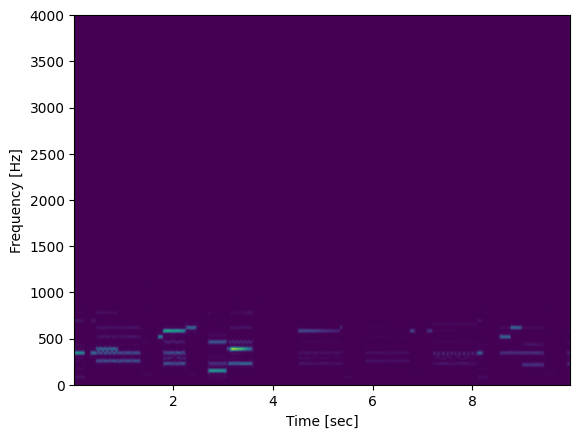

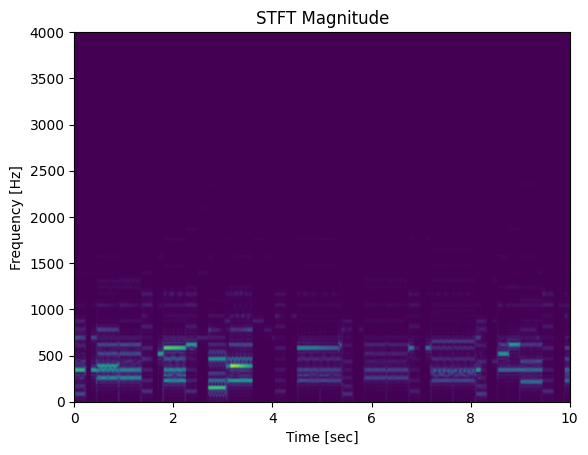

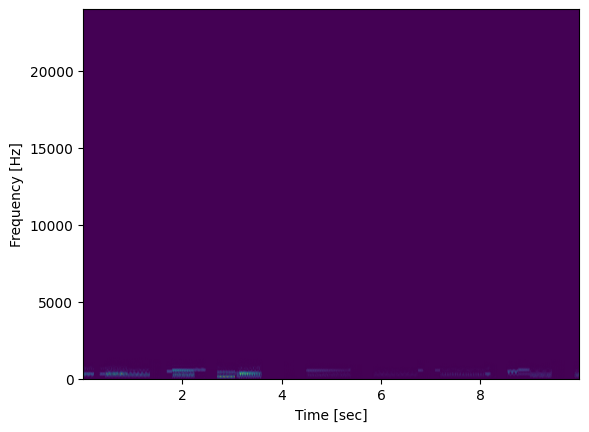

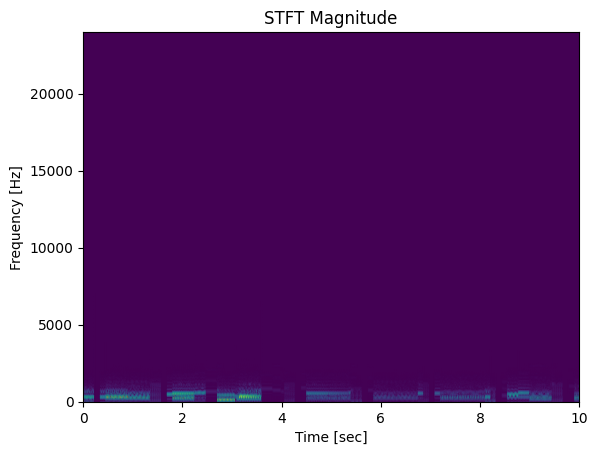

In [16]:
s, fs = sf.read('../audio/out_8k.wav')
f, t, Sxx = sp.spectrogram(s, fs, window=('tukey', 0.3), noverlap=0, nfft=512)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = sp.stft(s, fs, window=('tukey', 0.3), noverlap=0, nfft=512)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

s, fs = sf.read('../audio/out_48k.wav')
f, t, Sxx = sp.spectrogram(s, fs, window=('tukey', 0.3), noverlap=0, nfft=2048)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = sp.stft(s, fs, window=('tukey', 0.3), noverlap=0, nfft=2048)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
